In [2]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-v6vs39sx
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-v6vs39sx
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [3]:
!pip install faiss_cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 57.6 MB/s eta 0:00:00:00:0100:01


In [29]:
import json
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn.functional as F
import clip
import numpy as np
import faiss

# === Load CLIP model ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

# === Đường dẫn COCO ===
val_image_dir = Path("/kaggle/input/coco-2017-dataset/coco2017/val2017")
caption_json_path = "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_val2017.json"

# === Load caption annotations ===
with open(caption_json_path, 'r') as f:
    full_json = json.load(f)

caption_data = full_json['annotations']
image_id_to_filename = {img['id']: img['file_name'] for img in full_json['images']}

# === Tạo list caption & map image_id → list caption ===
caption_list = []              # [(image_id, caption)]
image_id_to_captions = {}      # {image_id: [caption1, caption2, ...]}

for ann in caption_data:
    img_id = ann['image_id']
    caption = ann['caption']
    caption_list.append((img_id, caption))
    image_id_to_captions.setdefault(img_id, []).append(caption)

# === Encode caption → embedding ===
def encode_texts_in_batches(captions, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(captions), batch_size), desc="Encoding captions"):
        batch = captions[i:i+batch_size]
        tokens = clip.tokenize(batch).to(device)
        with torch.no_grad():
            emb = model.encode_text(tokens).cpu()
        embeddings.append(emb)
    return torch.cat(embeddings)

captions_only = [c for _, c in caption_list]
text_embeddings = encode_texts_in_batches(captions_only)

# === Lấy ảnh có thật sự tồn tại trên ổ đĩa ===
val_image_paths, val_image_ids = [], []

for img_id, fname in image_id_to_filename.items():
    path = val_image_dir / fname
    if path.exists():
        val_image_paths.append(path)
        val_image_ids.append(img_id)

# === Encode ảnh → embedding ===
def encode_images_in_batches(image_paths, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Encoding images"):
        batch_paths = image_paths[i:i+batch_size]
        images = []
        for p in batch_paths:
            try:
                img = preprocess(Image.open(p).convert("RGB"))
                images.append(img)
            except:
                continue
        if not images:
            continue
        input_tensor = torch.stack(images).to(device)
        with torch.no_grad():
            emb = model.encode_image(input_tensor).cpu()
        embeddings.append(emb)
    return torch.cat(embeddings)

image_embeddings = encode_images_in_batches(val_image_paths)

# === FAISS setup ===
text_embeddings_np = F.normalize(text_embeddings, dim=1).numpy().astype('float32')
image_embeddings_np = F.normalize(image_embeddings, dim=1).numpy().astype('float32')

index = faiss.IndexFlatIP(text_embeddings_np.shape[1])  # inner product = cosine if normalized
index.add(text_embeddings_np)

top_k = 10
distances, indices = index.search(image_embeddings_np, top_k)  # (num_images, top_k)

# === Tính recall và rank ===
ranks = []

for i, image_id in enumerate(val_image_ids):
    gt_indices = [j for j, (img_id, _) in enumerate(caption_list) if img_id == image_id]
    preds = indices[i].tolist()
    rank = min([preds.index(gt_idx) for gt_idx in gt_indices if gt_idx in preds] + [top_k])
    ranks.append(rank)

ranks = np.array(ranks)
r1 = 100.0 * np.mean(ranks < 1)
r5 = 100.0 * np.mean(ranks < 5)
r10 = 100.0 * np.mean(ranks < 10)
mean_rank = np.mean(ranks) + 1
median_rank = np.median(ranks) + 1

# === In kết quả ===
print("\n🎯 Retrieval metrics (Image → Caption, FAISS):")
print(f"Recall@1   : {r1:.2f}%")
print(f"Recall@5   : {r5:.2f}%")
print(f"Recall@10  : {r10:.2f}%")
print(f"Median Rank: {median_rank:.1f}")
print(f"Mean Rank  : {mean_rank:.1f}")

Encoding images: 100%|██████████| 157/157 [00:55<00:00,  2.85it/s]



🎯 Retrieval metrics (Image → Caption, FAISS):
Recall@1   : 49.92%
Recall@5   : 74.94%
Recall@10  : 83.24%
Median Rank: 2.0
Mean Rank  : 3.7


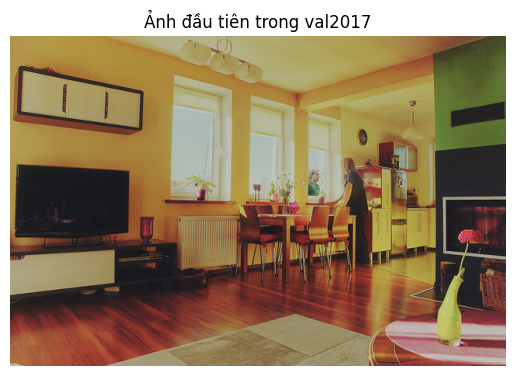


📝 Top-10 caption được truy xuất cho ảnh ID 139 (000000000139.jpg):

 1. [image_id=415194] An old fashioned kitchen is set up for display.
 2. [image_id=52996] Two woman soldiers talking to other women in a kitchen
 3. [image_id=199771] People in a kitchen with cooking attire on
 4. [image_id=78266] The cramped interior of a passenger ship's kitchen.
 5. [image_id=215644] A kitchen is shown in midst of repairs.
 6. [image_id=397133] A table with pies being made and a person standing near a wall with pots and pans hanging on the wall.
 7. [image_id=322163] A couple of guys cooking in a restaruant kitchen that is open to the restaurant.
 8. [image_id=520264] A man and a woman stand next to each other in a kitchen.
 9. [image_id=292060] a kitchen full of cabinets, a stove, sink and refridgeratio
10. [image_id=322163] A group of three chefs preparing food in a kitchen.

📌 Caption gốc của ảnh ID 139:

• A woman stands in the dining area at the table.
• A room with chairs, a table, and a wom

In [23]:
import matplotlib.pyplot as plt
from pathlib import Path

# === Lấy ảnh đầu tiên và kết quả truy xuất ===
first_image_idx = 0
first_image_path = val_image_paths[first_image_idx]  # đây có thể là Path hoặc str
first_image_id = val_image_ids[first_image_idx]
first_caption_indices = indices[first_image_idx]

# === Hiển thị ảnh ===
img = Image.open(first_image_path).convert("RGB")
plt.imshow(img)
plt.axis("off")
plt.title("Ảnh đầu tiên trong val2017")
plt.show()

# === In caption truy xuất ===
filename = Path(first_image_path).name  # đảm bảo có .name
print(f"\n📝 Top-{top_k} caption được truy xuất cho ảnh ID {first_image_id} ({filename}):\n")

for rank_idx, cap_idx in enumerate(first_caption_indices):
    img_id, caption = caption_list[cap_idx]
    print(f"{rank_idx+1:2d}. [image_id={img_id}] {caption}")

# === In caption gốc ===
print(f"\n📌 Caption gốc của ảnh ID {first_image_id}:\n")
for cap in image_id_to_captions[first_image_id]:
    print("•", cap)






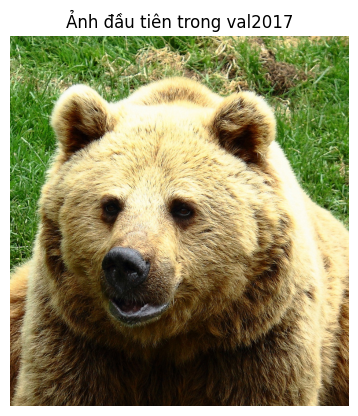


📝 Top-10 caption được truy xuất cho ảnh ID 285 (000000000285.jpg):

 1. [image_id=446005] An empty kitchen is photographed as if for a real estate listing.
 2. [image_id=445658] A kitchen area features a white refrigerator a stove and other appliances and brown cabinets.
 3. [image_id=407614] an orange kitchen with a white refrigerator stove oven and dishwasher
 4. [image_id=407614] The kitchen is coral with wooden cabinets and colorful decorations.
 5. [image_id=365766] The small kitchen with the spacious counters is clean.
 6. [image_id=237928] This kitchen has a black stove, stainless steel refrigerator and white cupboards.
 7. [image_id=407614] Small family kitchen with picture covered refrigerator next to dining room.
 8. [image_id=472046] A large modern kitchen has pineapples on the counter.
 9. [image_id=109976] This is a small kitchen with white cabinets and appliances.
10. [image_id=222825] A bare kitchen has wood cabinets and white appliances. 

📌 Caption gốc của ảnh ID 285:

In [27]:
import matplotlib.pyplot as plt
from pathlib import Path

# === Lấy ảnh đầu tiên và kết quả truy xuất ===
first_image_idx = 2
first_image_path = val_image_paths[first_image_idx]  # đây có thể là Path hoặc str
first_image_id = val_image_ids[first_image_idx]
first_caption_indices = indices[first_image_idx]

# === Hiển thị ảnh ===
img = Image.open(first_image_path).convert("RGB")
plt.imshow(img)
plt.axis("off")
plt.title("Ảnh đầu tiên trong val2017")
plt.show()

# === In caption truy xuất ===
filename = Path(first_image_path).name  # đảm bảo có .name
print(f"\n📝 Top-{top_k} caption được truy xuất cho ảnh ID {first_image_id} ({filename}):\n")

for rank_idx, cap_idx in enumerate(first_caption_indices):
    img_id, caption = caption_list[cap_idx]
    print(f"{rank_idx+1:2d}. [image_id={img_id}] {caption}")

# === In caption gốc ===
print(f"\n📌 Caption gốc của ảnh ID {first_image_id}:\n")
for cap in image_id_to_captions[first_image_id]:
    print("•", cap)


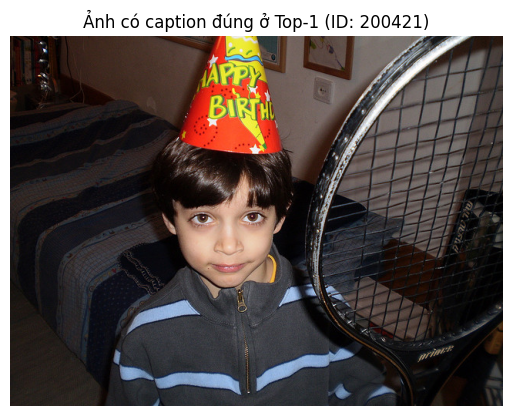


📌 Caption gốc của ảnh ID 200421:
• A boy in birthday hat holding a tennis racket.
• A small boy with a birthday hat on holding a tennis racket.
• A young boy in a birthday hat holds a tennis racquet
• a little boy wearing a birthday hat and holding a tennis racket
• A child holds a racket with a hat on his head.

🔍 Top-10 caption truy xuất được:

✅ Top-1: [image_id=200421] A child holds a racket with a hat on his head.
❌ Top-2: [image_id=323496] A boy swinging a tennis racket at a ball on a court.
❌ Top-3: [image_id=39951] A boy hitting a tennis all with a racquet.
❌ Top-4: [image_id=323496] A young boy in a red shirt playing tennis.
❌ Top-5: [image_id=323496] A young lad swings his Wilson tennis racquet.
❌ Top-6: [image_id=31217] a boy playing tennis runs to hit the ball 
❌ Top-7: [image_id=39951] A young boy taking a swing at a tennis ball
❌ Top-8: [image_id=410510] A young boy on a tennis court prepares to hit a tennis ball with his racquet.
❌ Top-9: [image_id=117744] a small girl 

In [26]:
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

found = False

for i, image_id in enumerate(val_image_ids):
    preds = indices[i]  # các chỉ số caption được truy xuất
    gt_indices = [j for j, (img_id, _) in enumerate(caption_list) if img_id == image_id]

    # Kiểm tra caption đúng có nằm ở Top-1 không
    if any(preds[0] == gt_idx for gt_idx in gt_indices):
        # ✅ Tìm được ảnh có caption đúng ở Top-1
        image_path = val_image_paths[i]
        img = Image.open(image_path).convert("RGB")
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Ảnh có caption đúng ở Top-1 (ID: {image_id})")
        plt.show()

        # In caption gốc
        print(f"\n📌 Caption gốc của ảnh ID {image_id}:")
        for cap in image_id_to_captions[image_id]:
            print("•", cap)

        # In toàn bộ top-10 caption truy xuất, đánh dấu caption đúng
        print(f"\n🔍 Top-10 caption truy xuất được:\n")
        for rank_idx, cap_idx in enumerate(preds):
            img_id, caption = caption_list[cap_idx]
            mark = "✅" if img_id == image_id else "❌"
            print(f"{mark} Top-{rank_idx+1}: [image_id={img_id}] {caption}")

        # In lại caption đúng ở Top-1
        matched_caption = caption_list[preds[0]][1]
        print(f"\n🎯 Caption đúng xuất hiện ở Top-1:")
        print(f"→ {matched_caption}")

        found = True
        break  # Chỉ cần 1 ảnh

if not found:
    print("❌ Không tìm thấy ảnh nào có caption đúng nằm ở Top-1.")
